<a href="https://colab.research.google.com/github/amalekia/car_clustering/blob/main/466_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Car Analysis**

In [ ]:
!pip install ISLP

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
from google.colab import userdata
from google.colab import drive

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# **Data Cleaning**

https://www.kaggle.com/datasets/doaaalsenani/usa-cers-dataset?resource=download

In [ ]:
# Read in used cars data
raw_url = 'https://raw.githubusercontent.com/andrewcheung27/csc466-project/main/used_cars_data_CLEAN.csv.zip'

cars = pd.read_csv('/content/used_cars_data_CLEAN.csv')
cars.head()

,city_fuel_economy,height,highway_fuel_economy,horsepower,length,make_name,mileage,model_name,price,year
0,NaN,66.5,NaN,177.0,166.6,Jeep,7.0,Renegade,23141.0,2019
1,NaN,68,NaN,246.0,181,Land Rover,8.0,Discovery Sport,46500.0,2020
2,17.0,58.1,23.0,305.0,180.9,Subaru,NaN,WRX STI,46995.0,2016
3,NaN,73,NaN,340.0,195.1,Land Rover,11.0,Discovery,67430.0,2020
4,NaN,68,NaN,246.0,181,Land Rover,7.0,Discovery Sport,48880.0,2020


<Axes: xlabel='mean_fuel_economy', ylabel='price'>

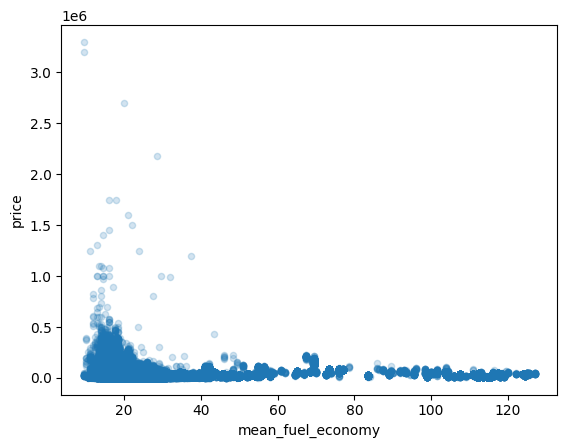

In [ ]:
# Convert price to a float and create mean_fuel_economy column
cars['price'] = cars['price'].astype(float)
cars['mean_fuel_economy'] = (cars['city_fuel_economy'] + cars['highway_fuel_economy']) / 2

# Plot cars price vs. mean fuel economy
cars.plot.scatter(x='mean_fuel_economy', y='price', alpha=0.2)

In [ ]:
# Make smaller sample
sample = cars.copy().dropna().sample(n=10000, random_state=1).reset_index(drop=True)
sample.to_csv()

',city_fuel_economy,height,highway_fuel_economy,horsepower,length,make_name,mileage,model_name,price,year,mean_fuel_economy\n0,14.0,74.4,21.0,355.0,224.4,Chevrolet,26002.0,Suburban,45998.0,2019,17.5\n1,29.0,57.1,35.0,192.0,192.2,Honda,10.0,Accord,27935.0,2020,32.0\n2,25.0,62.5,32.0,141.0,172.8,Nissan,5.0,Rogue Sport,24713.0,2020,28.5\n3,22.0,64.5,27.0,241.0,183.3,Mercedes-Benz,7476.0,GLC-Class,43800.0,2019,24.5\n4,17.0,70.6,24.0,308.0,212.7,Chevrolet,5.0,Colorado,40560.0,2021,20.5\n5,16.0,75.5,22.0,420.0,231.7,Chevrolet,3.0,Silverado 1500,48581.0,2020,19.0\n6,18.0,77.2,23.0,375.0,231.9,Ford,7.0,F-150,44253.0,2020,20.5\n7,30.0,57.4,40.0,153.0,183.7,Chevrolet,60060.0,Cruze,11991.0,2017,35.0\n8,16.0,75.5,21.0,285.0,231.7,Chevrolet,0.0,Silverado 1500,32265.0,2020,18.5\n9,15.0,72.3,19.0,205.0,184.4,Jeep,172206.0,Wrangler Unlimited,17110.0,2009,17.0\n10,41.0,67,38.0,219.0,180.9,Toyota,0.0,RAV4 Hybrid,31338.0,2020,39.5\n11,26.0,65.3,31.0,153.0,168.4,Buick,26479.0,Encore,17900.0,2017,28.5\n12,

In [ ]:
sample = pd.read_csv('/content/sample.csv').dropna()
sample['mean_fuel_economy'] = (sample['city_fuel_economy'] + sample['highway_fuel_economy']) / 2
sample.head()

,Unnamed: 0,city_fuel_economy,height,highway_fuel_economy,horsepower,length,make_name,mileage,model_name,price,year,mean_fuel_economy
0,0,14.0,74.4,21.0,355.0,224.4,Chevrolet,26002.0,Suburban,45998.0,2019,17.5
1,1,29.0,57.1,35.0,192.0,192.2,Honda,10.0,Accord,27935.0,2020,32.0
2,2,25.0,62.5,32.0,141.0,172.8,Nissan,5.0,Rogue Sport,24713.0,2020,28.5
3,3,22.0,64.5,27.0,241.0,183.3,Mercedes-Benz,7476.0,GLC-Class,43800.0,2019,24.5
4,4,17.0,70.6,24.0,308.0,212.7,Chevrolet,5.0,Colorado,40560.0,2021,20.5


In [ ]:
# Training features
X_train = sample[['price', 'horsepower', 'year', 'mean_fuel_economy', 'mileage']]

# Standardize the features
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)

# **KMeans Model**

In [ ]:
# Calculate distortions and inertias to plot distortions vs. k, in order to find the best k-value
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    # scikit uses kmeans++
    kmeanModel = KMeans(n_clusters=k).fit(X_train_std)
    kmeanModel.fit(X_train_std)

    distortions.append(sum(np.min(cdist(X_train_std, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train_std.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_train_std, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train_std.shape[0]
    mapping2[k] = kmeanModel.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10

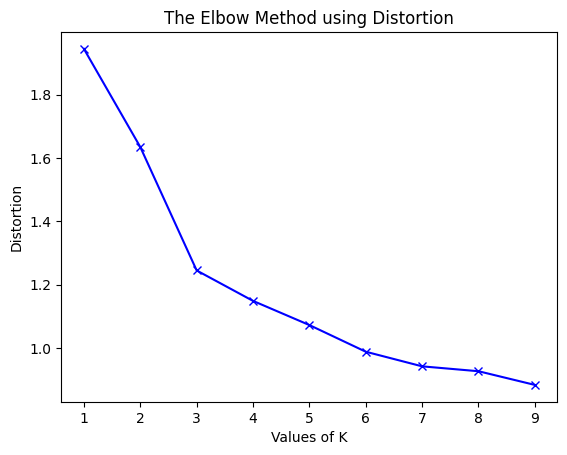

In [ ]:
# Plot the elbow method to find the best k-value (k=3)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Make KMeans model
model = KMeans(n_clusters=3)
model.fit(X_train_std)

# Map the cluster numbers to colors.
clusters = pd.Series(model.labels_).map({
    0: 'orange',
    1: 'blue',
    2: 'green'
})

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Text(0.5, 0, 'Year')

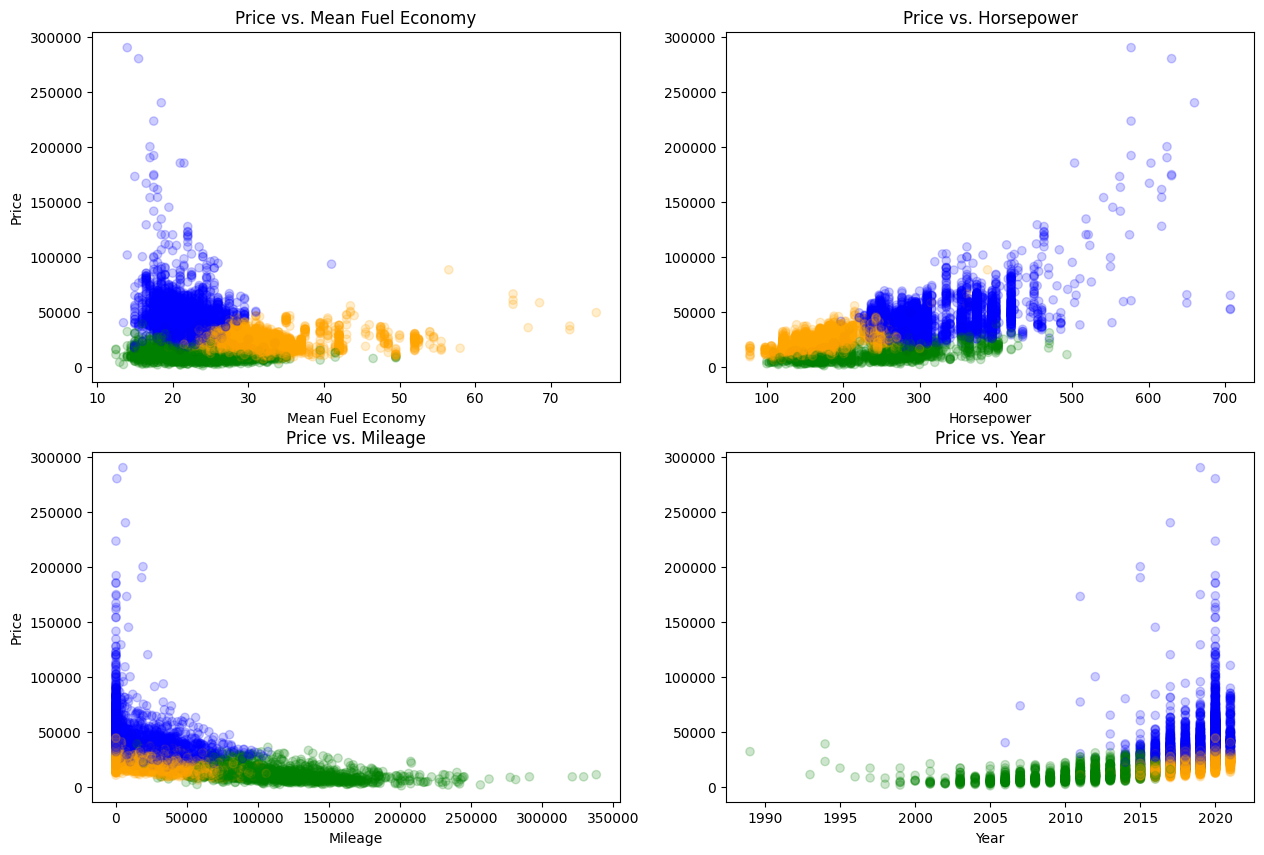

In [ ]:
# Initialise the subplot function using number of rows and columns
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the features by price
ax[0, 0].scatter(x='mean_fuel_economy', y='price', c=clusters, alpha=0.2, data=X_train)
ax[0, 1].scatter(x='horsepower', y='price', c=clusters, alpha=0.2, data=X_train)
ax[1, 0].scatter(x='mileage', y='price', c=clusters, alpha=0.2, data=X_train)
ax[1, 1].scatter(x='year', y='price', c=clusters, alpha=0.2, data=X_train)

ax[0, 0].set_title('Price vs. Mean Fuel Economy')
ax[0, 0].set_xlabel('Mean Fuel Economy')
ax[0, 0].set_ylabel('Price')
ax[0, 1].set_title('Price vs. Horsepower')
ax[0, 1].set_xlabel('Horsepower')
ax[1, 0].set_title('Price vs. Mileage')
ax[1, 0].set_xlabel('Mileage')
ax[1, 0].set_ylabel('Price')
ax[1, 1].set_title('Price vs. Year')
ax[1, 1].set_xlabel('Year')

<Axes: >

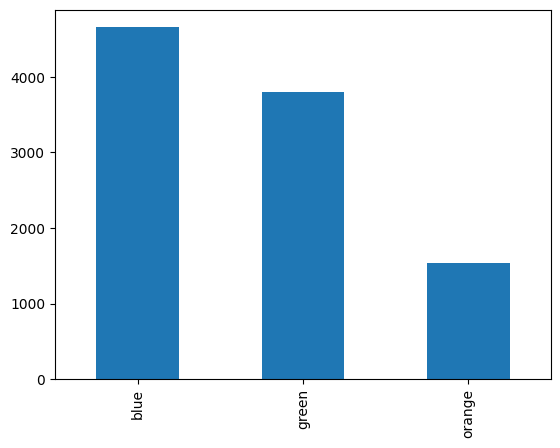

In [ ]:
# Plot the number of cars in each cluster
clusters.value_counts().plot.bar()

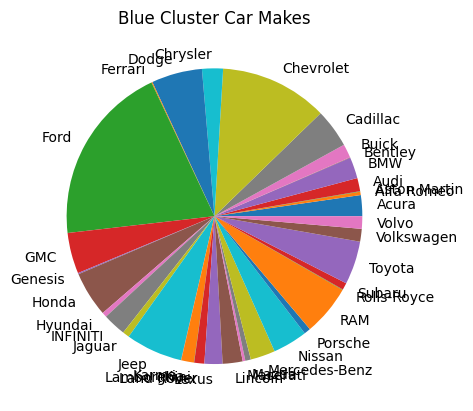

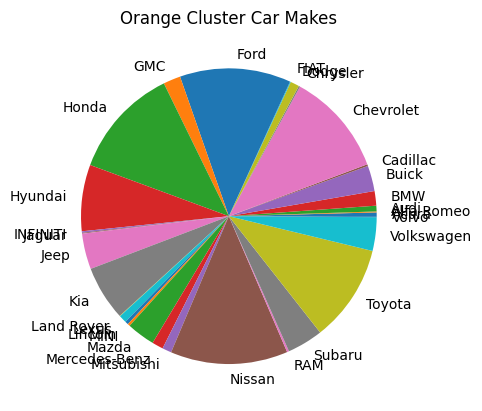

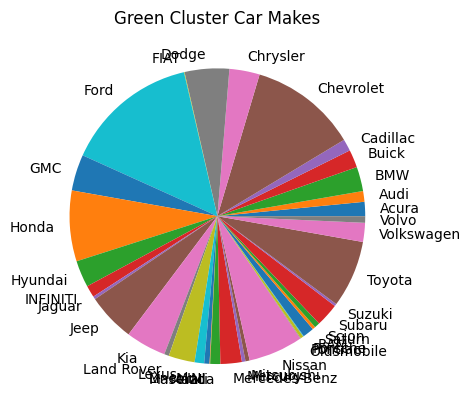

In [ ]:
# Add the clusters as a column
sample.loc[:, 'cluster'] = clusters

# Plot a pie chart for each cluster of the car make distributions
blue = sample[sample['cluster'] == 'blue'].groupby(['make_name'])['make_name'].count().reset_index(name='count')
orange = sample[sample['cluster'] == 'orange'].groupby(['make_name'])['make_name'].count().reset_index(name='count')
green = sample[sample['cluster'] == 'green'].groupby(['make_name'])['make_name'].count().reset_index(name='count')

# Plot the car make counts
plt.figure(0)
plt.title('Blue Cluster Car Makes')
plt.pie(blue['count'], labels=blue['make_name']);
plt.figure(1)
plt.title('Orange Cluster Car Makes')
plt.pie(orange['count'], labels=orange['make_name']);
plt.figure(2)
plt.title('Green Cluster Car Makes')
plt.pie(green['count'], labels=green['make_name']);

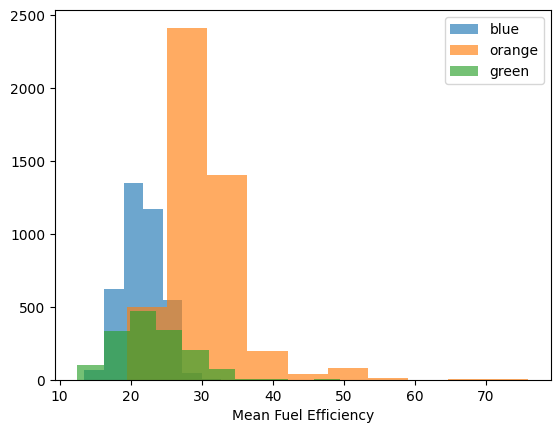

In [ ]:
# Plot the mean fuel economy distributions for each cluster
plt.hist(sample[sample['cluster'] == 'blue']['mean_fuel_economy'], label='blue', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'orange']['mean_fuel_economy'], label='orange', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'green']['mean_fuel_economy'], label='green', alpha=0.65)

plt.legend(loc='upper right')
plt.xlabel('Mean Fuel Efficiency')
plt.show()

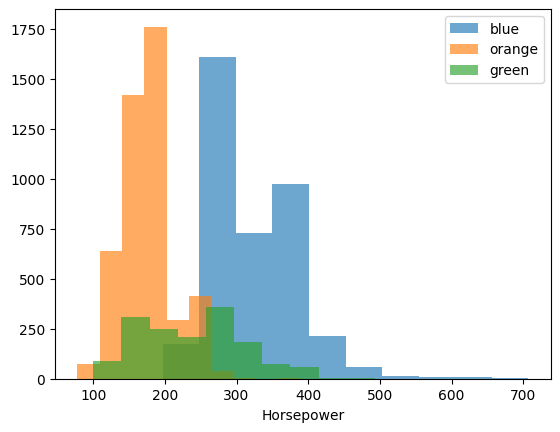

In [ ]:
# Plot the horsepower distributions for each cluster
plt.hist(sample[sample['cluster'] == 'blue']['horsepower'], label='blue', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'orange']['horsepower'], label='orange', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'green']['horsepower'], label='green', alpha=0.65)

plt.legend(loc='upper right')
plt.xlabel('Horsepower')
plt.show()

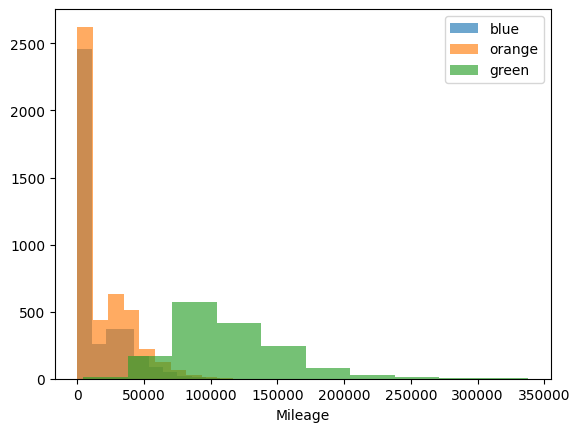

In [ ]:
# Plot the mileage distributions for each cluster
plt.hist(sample[sample['cluster'] == 'blue']['mileage'], label='blue', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'orange']['mileage'], label='orange', alpha=0.65)
plt.hist(sample[sample['cluster'] == 'green']['mileage'], label='green', alpha=0.65)

plt.legend(loc='upper right')
plt.xlabel('Mileage')
plt.show()

# **Hierarchical Clustering Model**

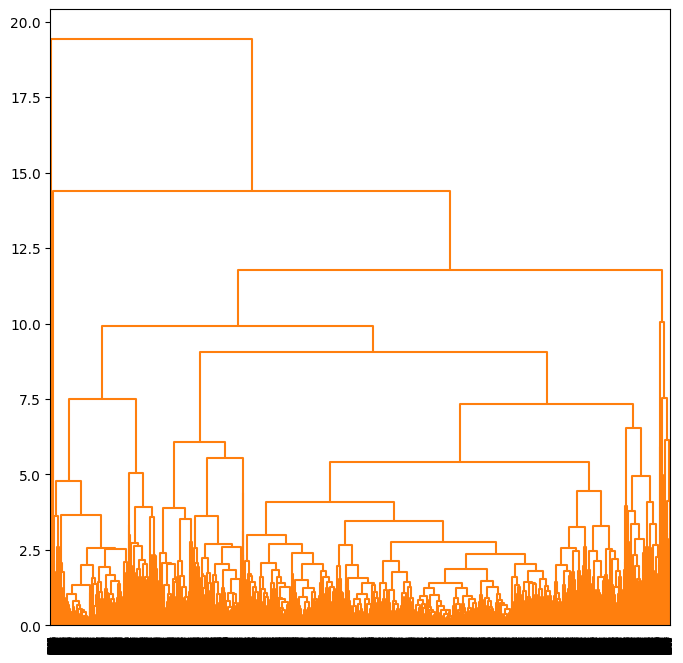

In [ ]:
# Create a dendrogram
hc_complete = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
hc_complete.fit(X_train_std)

linkage_complete = compute_linkage(hc_complete)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_complete, ax=ax, color_threshold=np.inf, above_threshold_color='black');

In [ ]:
# Make the clusters for the hierarchical clustering model
colors = {
    0:'green',
    1:'blue',
    2:'orange'
}
clusters_ = cut_tree(linkage_complete, n_clusters=3).T[0]
clusters = pd.Series(clusters_).map(colors)

Text(0.5, 0, 'Year')

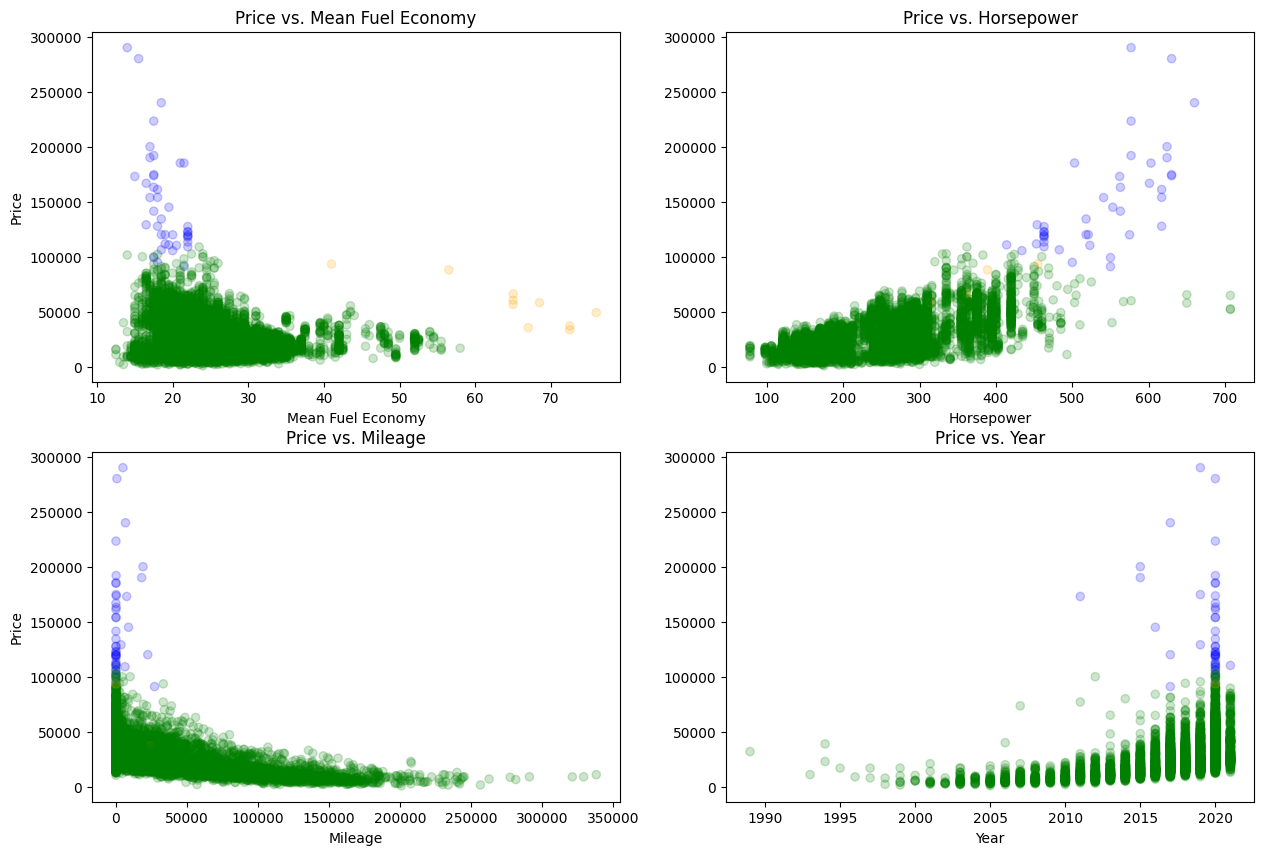

In [ ]:
# Initialise the subplot function using number of rows and columns
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot the features by price
ax[0, 0].scatter(x='mean_fuel_economy', y='price', c=clusters, alpha=0.2, data=X_train)
ax[0, 1].scatter(x='horsepower', y='price', c=clusters, alpha=0.2, data=X_train)
ax[1, 0].scatter(x='mileage', y='price', c=clusters, alpha=0.2, data=X_train)
ax[1, 1].scatter(x='year', y='price', c=clusters, alpha=0.2, data=X_train)

ax[0, 0].set_title('Price vs. Mean Fuel Economy')
ax[0, 0].set_xlabel('Mean Fuel Economy')
ax[0, 0].set_ylabel('Price')
ax[0, 1].set_title('Price vs. Horsepower')
ax[0, 1].set_xlabel('Horsepower')
ax[1, 0].set_title('Price vs. Mileage')
ax[1, 0].set_xlabel('Mileage')
ax[1, 0].set_ylabel('Price')
ax[1, 1].set_title('Price vs. Year')
ax[1, 1].set_xlabel('Year')

<Axes: >

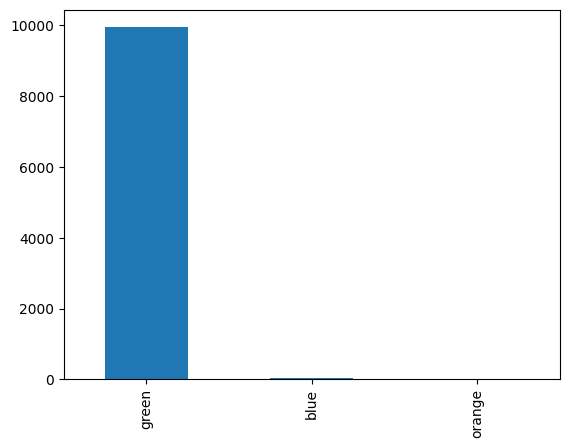

In [ ]:
# Plot the number of cars in each cluster
clusters.value_counts().plot.bar()

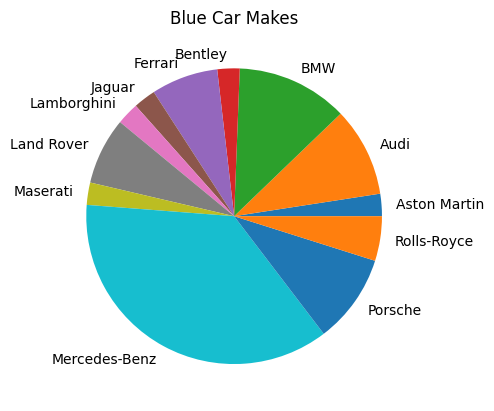

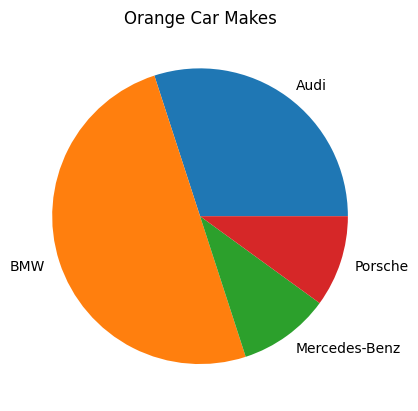

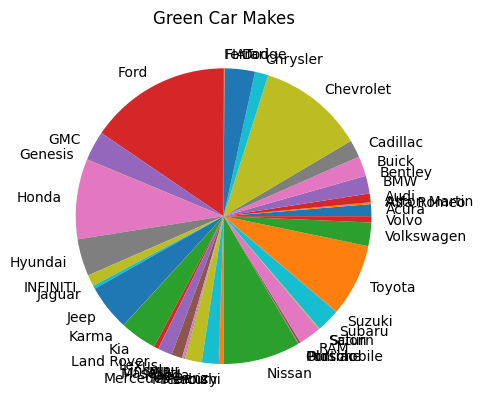

In [ ]:
# Add the clusters as a column
sample.loc[:, 'cluster'] = clusters

# Plot a pie chart for each cluster of the car make distributions
blue = sample[sample['cluster'] == 'blue'].groupby(['make_name'])['make_name'].count().reset_index(name='count')
orange = sample[sample['cluster'] == 'orange'].groupby(['make_name'])['make_name'].count().reset_index(name='count')
green = sample[sample['cluster'] == 'green'].groupby(['make_name'])['make_name'].count().reset_index(name='count')

# Plot the features by price
plt.figure(0)
plt.title('Blue Car Makes')
plt.pie(blue['count'], labels=blue['make_name']);
plt.figure(1)
plt.title('Orange Car Makes')
plt.pie(orange['count'], labels=orange['make_name']);
plt.figure(2)
plt.title('Green Car Makes')
plt.pie(green['count'], labels=green['make_name']);

# **Analysis**

In [ ]:
# Distribution of car makes in the sample, some are much less prevalent than
# others, which can lead to skewed data
sample['make_name'].value_counts()

Ford             1544
Chevrolet        1156
Honda             872
Nissan            834
Toyota            788
Jeep              499
Hyundai           403
Kia               400
Dodge             331
GMC               319
Volkswagen        256
Subaru            251
RAM               239
Buick             217
BMW               203
Mercedes-Benz     196
Cadillac          190
Mazda             184
Lexus             158
Chrysler          145
Acura             130
INFINITI          124
Lincoln           116
Audi              102
Volvo              68
Mitsubishi         54
Land Rover         52
Jaguar             37
Porsche            28
MINI               21
Alfa Romeo         19
Maserati           12
Scion               9
Mercury             6
Genesis             5
FIAT                5
Pontiac             5
Saturn              5
Ferrari             4
Suzuki              4
Bentley             2
Rolls-Royce         2
Aston Martin        2
Karma               1
Oldsmobile          1
Lamborghin

<Axes: ylabel='Frequency'>

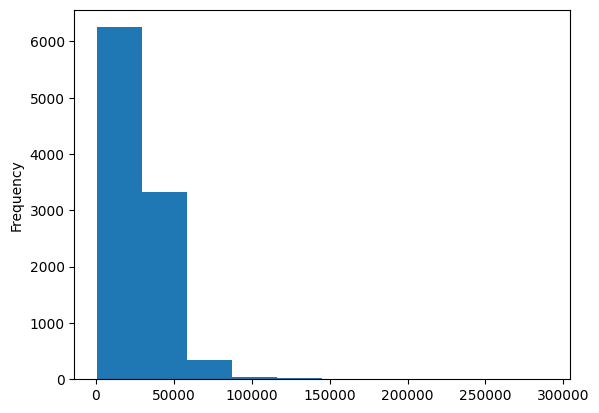

In [ ]:
# A skew in prices shows that lower-priced cars are much more common, which
# again may cause some skewed results, with more unpredictability for more
# expensive cars
sample['price'].plot.hist()